# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


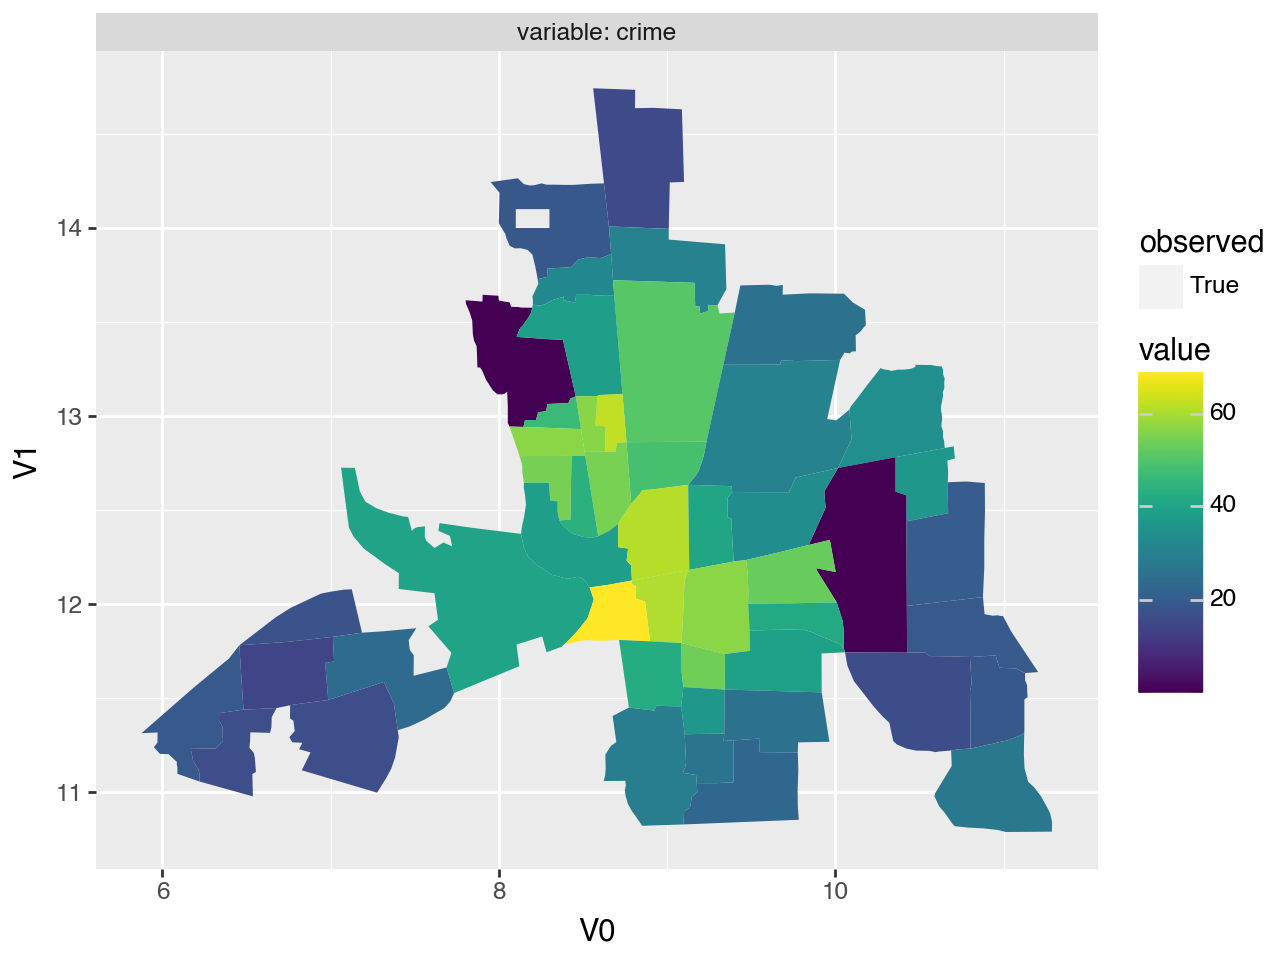

In [3]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

In [4]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y,label,observed
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076,0,True
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624,1,True
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719,2,True
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962,3,True
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366,4,True


## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.lin("area")

# I use scale=1.0 for demo; otherwise there's no nonlinearity
smooth = tb.ps("income", scale=1.0, k=20)
loc += tb.vc("area", by=smooth)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


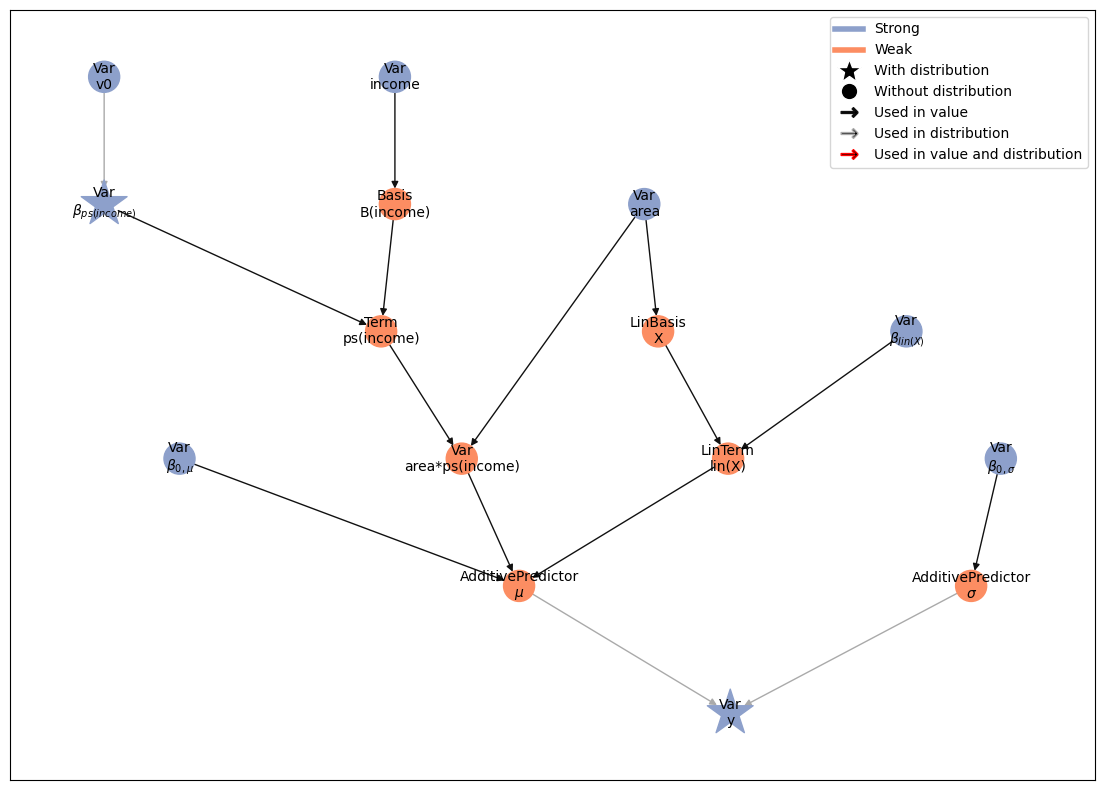

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ps(income)}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  4.58chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1181.83chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 0, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:0

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                               kernel       mean         sd     q_0.05  \
parameter            index                                               
$\beta_{0,\mu}$      ()     kernel_01  43.588264   3.350207  38.123726   
$\beta_{0,\sigma}$   ()     kernel_00   2.579460   0.107258   2.407626   
$\beta_{lin(X)}$     (0,)   kernel_03 -36.079235  15.215193 -60.851180   
$\beta_{ps(income)}$ (0,)   kernel_02  -0.009877   1.002457  -1.685092   
                     (1,)   kernel_02  -0.010386   1.007644  -1.704725   
                     (2,)   kernel_02  -0.005540   0.989395  -1.633022   
                     (3,)   kernel_02   0.001480   0.988083  -1.607530   
                     (4,)   kernel_02  -0.025345   0.988590  -1.644593   
                     (5,)   kernel_02  -0.035496   0.992579  -1.662185   
                     (6,)   kernel_02  -0.065526   1.015628  -1.711457   
                     (7,)   kernel_02  -0.014532   0.969120  -1.609637   
                     (8,)   kernel_02   0.025177   1.003765  -1.626899   
                     (9,)   kernel_02  -0.044438   1.019729  -1.701019   
                     (10,)  kernel_02   0.030919   1.002310  -1.604047   
                     (11,)  kernel_02  -0.010977   0.997672  -1.677463   
                     (12,)  kernel_02   0.037088   0.988455  -1.605062   
                     (13,)  kernel_02  -0.111652   0.989705  -1.744122   
                     (14,)  kernel_02   0.134527   0.983174  -1.451313   
                     (15,)  kernel_02  -0.207129   0.984742  -1.856570   
                     (16,)  kernel_02   0.683239   0.927436  -0.833750   
                     (17,)  kernel_02   0.658121   0.648886  -0.412197   
                     (18,)  kernel_02 -10.465618   2.602622 -14.727971   

                                q_0.5     q_0.95  sample_size     ess_bulk  \
parameter            index                                                   
$\beta_{0,\mu}$      ()     43.599358  49.089220         4000  3421.976555   
$\beta_{0,\sigma}$   ()      2.576278   2.762149         4000  3347.830475   
$\beta_{lin(X)}$     (0,)  -36.070982 -11.803499         4000  3300.042557   
$\beta_{ps(income)}$ (0,)   -0.002222   1.632632         4000  3595.225470   
                     (1,)    0.010620   1.615009         4000  3588.303102   
                     (2,)   -0.021346   1.616623         4000  3402.816441   
                     (3,)    0.002787   1.609259         4000  3235.353035   
                     (4,)   -0.020878   1.638961         4000  3672.732347   
                     (5,)   -0.027945   1.617972         4000  3536.676220   
                     (6,)   -0.073321   1.567378         4000  3441.448501   
                     (7,)   -0.021828   1.591124         4000  3827.380922   
                     (8,)    0.029788   1.679092         4000  2967.685859   
                     (9,)   -0.047004   1.589079         4000  3594.395322   
                     (10,)   0.020758   1.635055         4000  3260.323258   
                     (11,)   0.000190   1.618119         4000  3470.856712   
                     (12,)   0.031840   1.695049         4000  3661.358393   
                     (13,)  -0.105162   1.507498         4000  3443.949915   
                     (14,)   0.144243   1.740376         4000  3428.157564   
                     (15,)  -0.197374   1.361365         4000  2985.628432   
                     (16,)   0.685243   2.229537         4000  3368.860250   
                     (17,)   0.663675   1.728857         4000  3194.071643   
                     (18,) -10.505739  -6.171540         4000  3025.495614   

                               ess_tail      rhat  
parameter            index                         
$\beta_{0,\mu}$      ()     3477.176220  0.999865  
$\beta_{0,\sigma}$   ()     3663.088704  1.000576  
$\beta_{lin(X)}$     (0,)   3265.833837  1.000579  
$\beta_{ps(income)}$ (0,)   3710.813583  0.999952  
                  

## Plots

In [10]:
samples = results.get_posterior_samples()

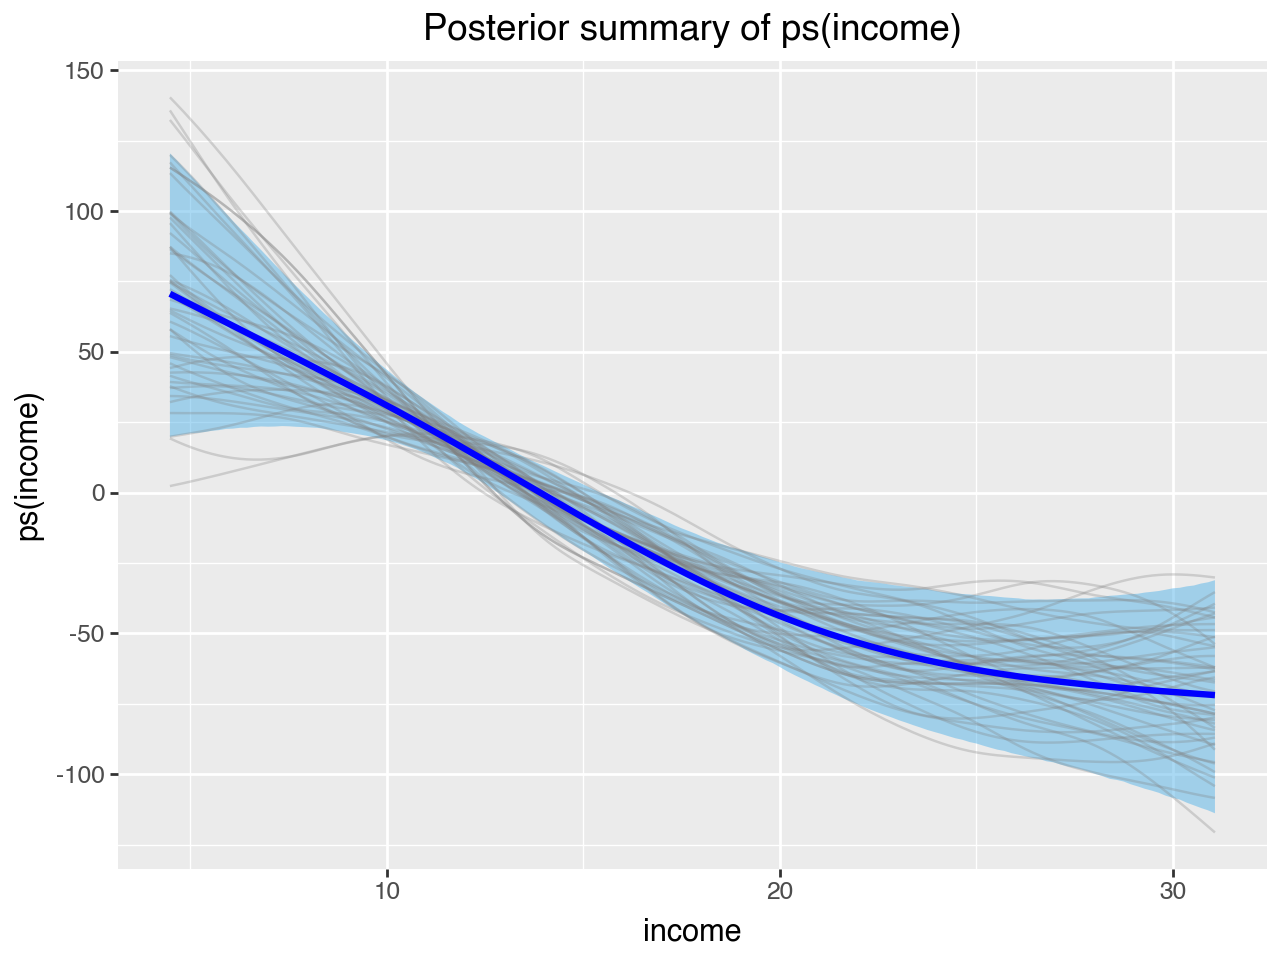

In [11]:
gam.plot_1d_smooth(term=model.vars["ps(income)"], samples=samples)